# Modeling and Simulation in Python

Chapter 23

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code from the previous chapter

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree

<Unit('degree')>

In [3]:
params = Params(x = 0 * m, 
                y = 1 * m,
                g = 9.8 * m/s**2,
                mass = 145e-3 * kg,
                diameter = 73e-3 * m,
                rho = 1.2 * kg/m**3,
                C_d = 0.3,
                angle = 45 * degree,
                velocity = 40 * m / s,
                t_end = 20 * s)

,values
x,0 meter
y,1 meter
g,9.8 meter / second ** 2
mass,0.145 kilogram
diameter,0.073 meter
rho,1.2 kilogram / meter ** 3
C_d,0.3
angle,45 degree
velocity,40.0 meter / second
t_end,20 second


In [4]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

In [5]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * V.mag**2 * C_d * area / 2
    direction = V.hat()
    f_drag = mag * direction
    return f_drag

In [6]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)    
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [7]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y

### Optimal launch angle

To find the launch angle that maximizes distance from home plate, we need a function that takes launch angle and returns range.

In [8]:
def range_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    x_dist = get_last_value(results.x) * m
    return x_dist

Let's test `range_func`.

In [9]:
%time range_func(45, params)

CPU times: user 68 ms, sys: 0 ns, total: 68 ms
Wall time: 65.7 ms


<Quantity(102.72776151763685, 'meter')>

And sweep through a range of angles.

In [10]:
angles = linspace(20, 80, 21)
sweep = SweepSeries()

for angle in angles:
    x_dist = range_func(angle, params)
    print(angle, x_dist)
    sweep[angle] = x_dist

20.0 79.96823513701818 meter
23.0 86.29628649188565 meter
26.0 91.59647908800758 meter
29.0 95.89089380357919 meter
32.0 99.20335822576222 meter
35.0 101.5566800797347 meter
38.0 102.9717388091764 meter
41.0 103.4674081317783 meter
44.0 103.06092247917795 meter
47.0 101.76845068606522 meter
50.0 99.60572853320409 meter
53.0 96.5886733164578 meter
56.0 92.7339915489423 meter
59.0 88.05990483905569 meter
62.0 82.58716276454999 meter
65.0 76.34016117578491 meter
68.0 69.34714056465752 meter
71.0 61.63878192638944 meter
74.0 53.25610154962806 meter
77.0 44.24668067783074 meter
80.0 34.67021301943231 meter


Plotting the `Sweep` object, it looks like the peak is between 40 and 45 degrees.

Saving figure to file figs/chap10-fig03.pdf


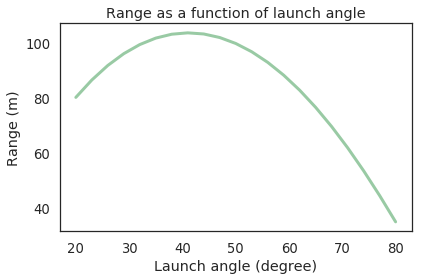

In [11]:
plot(sweep, color='C2')
decorate(xlabel='Launch angle (degree)',
         ylabel='Range (m)',
         title='Range as a function of launch angle',
         legend=False)

savefig('figs/chap10-fig03.pdf')

We can use `max_bounded` to search for the peak efficiently.

In [12]:
%time res = max_bounded(range_func, [0, 90], params)

CPU times: user 624 ms, sys: 0 ns, total: 624 ms
Wall time: 624 ms


`res` is an `ModSimSeries` object with detailed results:

In [13]:
res

,values
fun,103.46837822354604 meter
status,0
success,True
message,Solution found.
x,41.1391
nfev,9


`x` is the optimal angle and `fun` the optional range.

In [14]:
optimal_angle = res.x * degree

<Quantity(41.139142795603355, 'degree')>

In [15]:
max_x_dist = res.fun

<Quantity(103.46837822354604, 'meter')>

### Under the hood

Read the source code for `max_bounded` and `min_bounded`, below.

Add a print statement to `range_func` that prints `angle`.  Then run `max_bounded` again so you can see how many times it calls `range_func` and what the arguments are.

In [16]:
%psource max_bounded

def max_bounded(max_func, bounds, *args, **options):
    """Finds the input value that maximizes `max_func`.

    Wrapper for https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html

    min_func: computes the function to be maximized
    bounds: sequence of two values, lower and upper bounds of the
            range to be searched
    args: any additional positional arguments are passed to max_func
    options: any keyword arguments are passed as options to minimize_scalar

    returns: ModSimSeries object
    """
    def min_func(*args):
        return -max_func(*args)

    res = min_bounded(min_func, bounds, *args, **options)
    # we have to negate the function value before returning res
    res.fun = -res.fun
    return res


In [17]:
%psource min_bounded

def min_bounded(min_func, bounds, *args, **options):
    """Finds the input value that minimizes `min_func`.

    Wrapper for https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html

    min_func: computes the function to be minimized
    bounds: sequence of two values, lower and upper bounds of the
            range to be searched
    args: any additional positional arguments are passed to min_func
    options: any keyword arguments are passed as options to minimize_scalar

    returns: ModSimSeries object
    """
    # try:
    #     print(bounds[0])
    #     min_func(bounds[0], *args)
    # except Exception as e:
    #     msg = """Before running scipy.integrate.min_bounded, I tried
    #              running the slope function you provided with the
    #              initial conditions in system and t=0, and I got
    #              the following error:"""
    #     logger.error(msg)
    #     raise(e)

    underride(options, xatol=1e-3)

    # TOD

### The Manny Ramirez problem

Finally, let's solve the Manny Ramirez problem:

*What is the minimum effort required to hit a home run in Fenway Park?*

Fenway Park is a baseball stadium in Boston, Massachusetts.  One of its most famous features is the "Green Monster", which is a wall in left field that is unusually close to home plate, only 310 feet along the left field line.  To compensate for the short distance, the wall is unusually high, at 37 feet.

Although the problem asks for a minimum, it is not an optimization problem.  Rather, we want to solve for the initial velocity that just barely gets the ball to the top of the wall, given that it is launched at the optimal angle.

And we have to be careful about what we mean by "optimal".  For this problem, we don't want the longest range, we want the maximum height at the point where it reaches the wall.

If you are ready to solve the problem on your own, go ahead.  Otherwise I will walk you through the process with an outline and some starter code.

As a first step, write a function called `height_func` that takes a launch angle and a params as parameters, simulates the flights of a baseball, and returns the height of the baseball when it reaches a point 94.5 meters (310 feet) from home plate.

In [18]:
# Solution

def event_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object
    
    returns: height
    """
    x, y, vx, vy = state
    # TODO: add 94.5 as a system variable
    return x - 94.5 * m

Always test the slope function with the initial conditions.

In [19]:
# Solution

system = make_system(params)
event_func(system.init, 0, system)

<Quantity(-94.5, 'meter')>

In [20]:
# Solution

def height_func(angle, params):
    """Computes the height of the ball at the wall.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: height in meters
    """    
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    height = get_last_value(results.y) * m
    
    return height

Test your function with a launch angle of 45 degrees:

In [21]:
# Solution

height_func(45 * degree, params)

<Quantity(11.033479404035585, 'meter')>

Now use `max_bounded` to find the optimal angle.  Is it higher or lower than the angle that maximizes range?

In [22]:
# Solution

res = max_bounded(height_func, [0, 90], params)

,values
fun,11.04782805563806 meter
status,0
success,True
message,Solution found.
x,44.5406
nfev,12


In [23]:
# Solution

optimal_angle = res.x * degree

<Quantity(44.54061679801752, 'degree')>

In [24]:
# Solution

optimal_height = res.fun

<Quantity(11.04782805563806, 'meter')>

With initial velocity 40 m/s and an optimal launch angle, the ball clears the Green Monster with a little room to spare.

Which means we can get over the wall with a lower initial velocity.

### Finding the minimum velocity

Even though we are finding the "minimum" velocity, we are not really solving a minimization problem.  Rather, we want to find the velocity that makes the height at the wall exactly 11 m, given given that it's launched at the optimal angle.  And that's a job for `fsolve`.

Write an error function that takes a velocity and a `Params` object as parameters.  It should use `max_bounded` to find the highest possible height of the ball at the wall, for the given velocity.  Then it should return the difference between that optimal height and 11 meters.

In [25]:
# Solution

def error_func(velocity, params):
    """Returns the optimal height at the wall minus the target height.
    
    velocity: initial velocity in m/s
    params: Params object
    
    returns: height difference in meters
    """
    params = Params(params, velocity=velocity)
    res = max_bounded(height_func, [0, 90], params)
    return res.fun - 11 * m

Test your error function before you call `fsolve`.

In [26]:
# Solution

error_func(40 * m/s, params)

<Quantity(0.04782805563806036, 'meter')>

Then use `fsolve` to find the answer to the problem, the minimum velocity that gets the ball out of the park.

In [27]:
# Solution

res = fsolve(error_func, 40 * m/s, params)

array([39.98806408])

In [28]:
# Solution

min_velocity = res[0] * m/s

<Quantity(39.988064078851565, 'meter / second')>

And just to check, run `error_func` with the value you found.

In [29]:
# Solution

error_func(min_velocity, params)

<Quantity(2.051180558737542e-09, 'meter')>